### [Dataset citation]
##### <EyePACS dataset 2015>
- Emma Dugas, Jared, Jorge, Will Cukierski. (2015). Diabetic Retinopathy Detection. Kaggle. https://kaggle.com/competitions/diabetic-retinopathy-detection

##### <APTOS 2019>
- Karthik, Maggie, Sohier Dane. (2019). APTOS 2019 Blindness Detection. Kaggle. https://kaggle.com/competitions/aptos2019-blindness-detection

##### <INDIAN DIABETIC RETINOPATHY IMAGE DATASET (IDRID)>
- Prasanna Porwal, Samiksha Pachade, Ravi Kamble, Manesh Kokare, Girish Deshmukh, Vivek Sahasrabuddhe, Fabrice Meriaudeau, April 24, 2018, "Indian Diabetic Retinopathy Image Dataset (IDRiD)", IEEE Dataport, doi: https://dx.doi.org/10.21227/H25W98.
- https://www.kaggle.com/datasets/gami4388/diabetic-retinopathy-resized-train-15-19-dg?select=resized_train_15_19_DG

##### <Messidor 2>
- Abramoff et al, Automated analysis of retinal images for detection of referable diabetic retinopathy, JAMA Ophthalmol. 2013;131:351-7, and in Abramoff et al, Improved automated detection of diabetic retinopathy on a publicly available dataset through integration of deep learning, IOVS. 57:5200-06.
- https://medicine.uiowa.edu/eye/abramoff
- https://www.kaggle.com/datasets/mariaherrerot/messidor2preprocess/data

### [Package load]

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import glob
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import shutil

# 이걸 해줘야 matplotlib 시행 시 에러가 안 남
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### [Undersampling]

In [2]:
original_data_dir = '.\original data'
messidor_csv = pd.read_csv(os.path.join(original_data_dir,'labels','Messidor_data_Labels.csv'), index_col=0)
idrid_train_csv = pd.read_csv(os.path.join(original_data_dir,'labels','IDRID_training_Labels.csv'), index_col=0)
idrid_test_csv = pd.read_csv(os.path.join(original_data_dir,'labels','IDRID_test_Labels.csv'), index_col=0)
aptos15_train_csv = pd.read_csv(os.path.join(original_data_dir,'labels','APTOS15_train_Labels.csv'), index_col=0)
aptos15_test_csv = pd.read_csv(os.path.join(original_data_dir,'labels','APTOS15_test_Labels.csv'), index_col=0)
aptos19_train_csv = pd.read_csv(os.path.join(original_data_dir,'labels','APTOS19_train_Labels.csv'), index_col=0)

concat_csv = pd.concat([messidor_csv, idrid_train_csv, idrid_test_csv, aptos15_train_csv, aptos15_test_csv, aptos19_train_csv])
concat_csv = concat_csv.iloc[:,[0]]
concat_csv

,diagnosis
20051020_43808_0100_PP,0
20051020_43832_0100_PP,1
20051020_43882_0100_PP,1
20051020_43906_0100_PP,2
20051020_44261_0100_PP,0
...,...
ffa47f6a7bf4,2
ffc04fed30e6,0
ffcf7b45f213,2
ffd97f8cd5aa,0


In [3]:
concat_csv['diagnosis'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [4]:
concat_csv['diagnosis'].isnull().sum()

0

In [5]:
concat_csv['diagnosis'].value_counts(sort=False)

diagnosis
0    68333
1     6870
2    14667
3     2448
4     2306
Name: count, dtype: int64

In [6]:
round(concat_csv['diagnosis'].value_counts(sort=False, normalize=True)*100, 2)

diagnosis
0    72.22
1     7.26
2    15.50
3     2.59
4     2.44
Name: proportion, dtype: float64

array([[<Axes: title={'center': 'diagnosis'}>]], dtype=object)

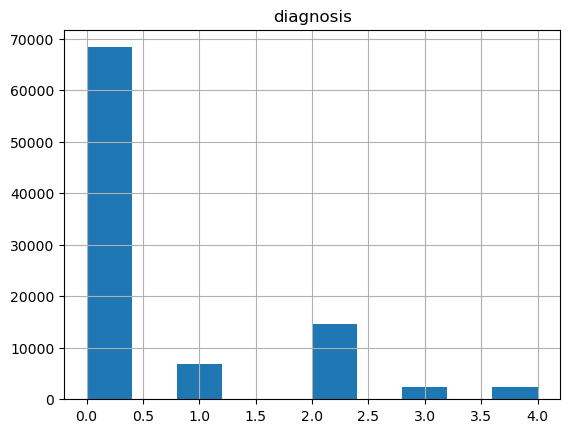

In [7]:
concat_csv.hist(column='diagnosis')

In [3]:
normal_original = concat_csv[concat_csv['diagnosis']==0]
mild_original = concat_csv[concat_csv['diagnosis']==1]
moderate_original = concat_csv[concat_csv['diagnosis']==2]
severe_original = concat_csv[concat_csv['diagnosis']==3]
pdr_original = concat_csv[concat_csv['diagnosis']==4]

##### Moving files

In [5]:
total_file_path = sorted(glob.glob(os.path.join(original_data_dir, 'Image','*', '*',)))
normal_id = normal_original.index.to_list()
mild_id = mild_original.index.to_list()
moderate_id = moderate_original.index.to_list()
severe_id = severe_original.index.to_list()
pdr_id = pdr_original.index.to_list()

print(len(normal_id), len(mild_id), len(moderate_id), len(severe_id), len(pdr_id))
print(len(normal_id)+ len(mild_id)+ len(moderate_id)+ len(severe_id)+ len(pdr_id))
print(len(total_file_path))

68333 6870 14667 2448 2306
94624
516


In [17]:
print('start moving...')
for path in tqdm(total_file_path):
    id = os.path.basename(path).split('.')[0]
    if id in normal_id:
        shutil.move(path, os.path.join(original_data_dir, 'sorted', '0'))
    elif id in mild_id:
        shutil.move(path, os.path.join(original_data_dir, 'sorted', '1'))
    elif id in moderate_id:
        shutil.move(path, os.path.join(original_data_dir, 'sorted', '2'))
    elif id in severe_id:
        shutil.move(path, os.path.join(original_data_dir, 'sorted', '3'))
    elif id in pdr_id:
        shutil.move(path, os.path.join(original_data_dir, 'sorted', '4'))
print('done!')

start moving...


  0%|          | 0/94624 [00:00<?, ?it/s]

done!


##### Downsampling

In [5]:
# Normal (diagnosis = 0)의 20%만 사용 (Undersampling)
normal_downsampling_original = normal_original.sample(frac=0.25, replace=False) # 비복원추출로 20% 뽑기
normal_downsampling_original_id = normal_downsampling_original.index.to_list()
normal_other = normal_original.drop(normal_downsampling_original_id)
normal_file_path = sorted(glob.glob(os.path.join(original_data_dir, 'sorted','0_original', '*',)))
for path in tqdm(normal_file_path):
    try:
        id = os.path.basename(path).split('.')[0]
        if id in normal_downsampling_original_id:
            shutil.move(path, os.path.join(original_data_dir, 'sorted', '0'))
    except:
        continue
print(len(sorted(glob.glob(os.path.join(original_data_dir, 'sorted','0', '*',)))))

  0%|          | 0/67518 [00:00<?, ?it/s]

16868


##### 이 사이에 매우 어둡거나 흐린 사진 삭제 과정을 거침

In [6]:
normal_path_after_remove = sorted(glob.glob(os.path.join(original_data_dir, 'sorted','0', '*',)))
normal_id_after_remove = [os.path.basename(x).split('.')[0] for x in normal_path_after_remove]
normal_id_removed = [x for x in normal_id if x not in normal_id_after_remove]
print(len(normal_id), len(normal_id_after_remove), len(normal_id_removed))

mild_path_after_remove = sorted(glob.glob(os.path.join(original_data_dir, 'sorted','1', '*',)))
mild_id_after_remove = [os.path.basename(x).split('.')[0] for x in mild_path_after_remove]
mild_id_removed = [x for x in mild_id if x not in mild_id_after_remove]
print(len(mild_id), len(mild_id_after_remove), len(mild_id_removed))

moderate_path_after_remove = sorted(glob.glob(os.path.join(original_data_dir, 'sorted','2', '*',)))
moderate_id_after_remove = [os.path.basename(x).split('.')[0] for x in moderate_path_after_remove]
moderate_id_removed = [x for x in moderate_id if x not in moderate_id_after_remove]
print(len(moderate_id), len(moderate_id_after_remove), len(moderate_id_removed))

severe_path_after_remove = sorted(glob.glob(os.path.join(original_data_dir, 'sorted','3', '*',)))
severe_id_after_remove = [os.path.basename(x).split('.')[0] for x in severe_path_after_remove]
severe_id_removed = [x for x in severe_id if x not in severe_id_after_remove]
print(len(severe_id), len(severe_id_after_remove), len(severe_id_removed))

pdr_path_after_remove = sorted(glob.glob(os.path.join(original_data_dir, 'sorted','4', '*',)))
pdr_id_after_remove = [os.path.basename(x).split('.')[0] for x in pdr_path_after_remove]
pdr_id_removed = [x for x in pdr_id if x not in pdr_id_after_remove]
print(len(pdr_id), len(pdr_id_after_remove), len(pdr_id_removed))

68333 14922 53411
6870 6787 83
14667 14257 410
2448 2333 115
2306 2208 98


In [7]:
normal_pd_after_remove = normal_original.drop(normal_id_removed, axis=0)
print(normal_pd_after_remove['diagnosis'].value_counts())

mild_pd_after_remove = mild_original.drop(mild_id_removed, axis=0)
print(mild_pd_after_remove['diagnosis'].value_counts())

moderate_pd_after_remove = moderate_original.drop(moderate_id_removed, axis=0)
print(moderate_pd_after_remove['diagnosis'].value_counts())

severe_pd_after_remove = severe_original.drop(severe_id_removed, axis=0)
print(severe_pd_after_remove['diagnosis'].value_counts())

pdr_pd_after_remove = pdr_original.drop(pdr_id_removed, axis=0)
print(pdr_pd_after_remove['diagnosis'].value_counts())

diagnosis
0    14922
Name: count, dtype: int64
diagnosis
1    6787
Name: count, dtype: int64
diagnosis
2    14257
Name: count, dtype: int64
diagnosis
3    2333
Name: count, dtype: int64
diagnosis
4    2208
Name: count, dtype: int64


### [Divide the Original Data into Train, Validation, and Test Data]

In [9]:
# 6:2:2로 downsampling
# Severe, PDR은 3:2:2로 나누기 -> 이후 training은 3배로 augmentation시키기
severe_pdr_csv = pd.concat([severe_pd_after_remove, pdr_pd_after_remove])

severe_pdr_train = severe_pdr_csv.sample(frac=0.43, replace=False)
severe_pdr_csv = severe_pdr_csv.drop(index=severe_pdr_train.index)
severe_pdr_val = severe_pdr_csv.sample(frac=0.5, replace = False)
severe_pdr_test = severe_pdr_csv.drop(severe_pdr_val.index)

other_csv = pd.concat([normal_pd_after_remove, mild_pd_after_remove, moderate_pd_after_remove])

other_train = other_csv.sample(frac=0.6, replace=False)
other_csv = other_csv.drop(other_train.index)
other_val = other_csv.sample(frac=0.5, replace = False)
other_test = other_csv.drop(other_val.index)

train_csv = pd.concat([severe_pdr_train, other_train])
val_csv = pd.concat([severe_pdr_val, other_val])
test_csv = pd.concat([severe_pdr_test, other_test])

In [10]:
print('len(train_csv): ', len(train_csv))
print('len(val_csv): ', len(val_csv))
print('len(test_csv): ', len(test_csv))

len(train_csv):  23533
len(val_csv):  8487
len(test_csv):  8487


In [11]:
train_csv['diagnosis'].value_counts(sort=False)

diagnosis
4     957
3     996
1    4093
0    9050
2    8437
Name: count, dtype: int64

In [12]:
val_csv['diagnosis'].value_counts(sort=False)

diagnosis
4     624
3     670
1    1353
2    2905
0    2935
Name: count, dtype: int64

In [13]:
test_csv['diagnosis'].value_counts(sort=False)

diagnosis
3     667
4     627
0    2937
1    1341
2    2915
Name: count, dtype: int64

In [14]:
data_dir = '.'
train_csv.to_csv(os.path.join(data_dir, 'train_label_original.csv'), index=True)
val_csv.to_csv(os.path.join(data_dir, 'val_label.csv'), index=True)
test_csv.to_csv(os.path.join(data_dir, 'test_label.csv'), index=True)

##### Upsampling: Data Augmentation

In [15]:
data_dir='.'
original_data_dir='.\original data'
train_csv = pd.read_csv(os.path.join(data_dir,'train_label_original.csv'), index_col=0)

In [16]:
train_csv['diagnosis'].value_counts(sort=False)

diagnosis
4     957
3     996
1    4093
0    9050
2    8437
Name: count, dtype: int64

In [17]:
severe_pdr_train = pd.concat([train_csv[train_csv['diagnosis']==3], train_csv[train_csv['diagnosis']==4]])
severe_and_pdr_train_id = severe_pdr_train.index.to_list()

In [18]:
# Severe NPDR + PDR Data augmentation
total_file_path = sorted(glob.glob(os.path.join(original_data_dir, 'sorted','*', '*',)))
severe_and_pdr_train_path = [x for x in total_file_path if os.path.basename(x).split('.')[0] in severe_and_pdr_train_id]
print(len(severe_and_pdr_train_path))

1953


In [19]:
# Augmentation -> augmentation 파일에 저장 -> CSV에도 추가하기
def augmentation(data_path):
    img = Image.open(data_path)
    transform = transforms.Compose([
        transforms.RandomRotation(180),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomChoice([
            transforms.RandomAdjustSharpness(0),
            transforms.RandomAdjustSharpness(1),
            transforms.RandomAdjustSharpness(2),
            transforms.RandomAdjustSharpness(3),
            ]),
        transforms.RandomPosterize(7, p=0.2),
        transforms.RandomResizedCrop(1300, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
    ])
    return transform(img)

aug_data_dir = os.path.join(original_data_dir,'sorted','aug')

In [20]:
for i in tqdm(range(1,3)):
    print('len(train_csv): ', len(train_csv))
    for x in tqdm(severe_and_pdr_train_path):
        img = augmentation(x)
        img_name = os.path.basename(x).split('.')[0]
        img.save(os.path.join(aug_data_dir, img_name+'_aug_'+str(i)+'.jpg'), 'JPEG')
        if train_csv['diagnosis'].loc[img_name] == 3:
            new_df = pd.DataFrame({'diagnosis': [3]}, index=[img_name+'_aug_'+str(i)])
        elif train_csv['diagnosis'].loc[img_name] == 4:
            new_df = pd.DataFrame({'diagnosis': [4]}, index=[img_name+'_aug_'+str(i)])
        train_csv = pd.concat([train_csv, new_df])

  0%|          | 0/2 [00:00<?, ?it/s]

len(train_csv):  23533


  0%|          | 0/1953 [00:00<?, ?it/s]

len(train_csv):  25486


  0%|          | 0/1953 [00:00<?, ?it/s]

In [21]:
train_csv.to_csv(os.path.join(data_dir, 'train_label.csv'), index=True)

In [22]:
train_csv = pd.read_csv(os.path.join(data_dir,'train_label.csv'), index_col=0)

In [23]:
train_csv['diagnosis'].value_counts(sort=False)

diagnosis
4    2871
3    2988
1    4093
0    9050
2    8437
Name: count, dtype: int64

In [24]:
val_csv = pd.read_csv(os.path.join(data_dir,'val_label.csv'), index_col=0)

In [25]:
val_csv['diagnosis'].value_counts(sort=False)

diagnosis
4     624
3     670
1    1353
2    2905
0    2935
Name: count, dtype: int64

In [26]:
test_csv = pd.read_csv(os.path.join(data_dir,'test_label.csv'), index_col=0)

In [27]:
test_csv['diagnosis'].value_counts(sort=False)

diagnosis
3     667
4     627
0    2937
1    1341
2    2915
Name: count, dtype: int64

### [Image Preprocessing]

In [2]:
original_data_dir = './original data'  # 압축 해제된 데이터셋의 디렉토리 경로

# For Kaggle notebook -> 확인할 것
#data_dir = '/kaggle/input/ /'

In [3]:
import math

def img_crop(img):
    # 대각선만큼 상하좌우 패딩
    img_h, img_w = img.shape[0], img.shape[1]
    diag = int((img_h**2 + img_w ** 2)**0.5)    # 대각선 길이 구하기
    add_h, add_w = int((diag - img_h)/2), int((diag - img_w)/2)     # 상하좌우에 각각 추가될 padding의 길이 구하기
    img = cv2.copyMakeBorder(img, add_h, add_h, add_w, add_w, cv2.BORDER_CONSTANT,value=0)  # 0이라는 CONSTANT (검은색)으로 가장자리 추가

    # actan만큼 회전
    img_h, img_w = img.shape[0], img.shape[1]
    degree = math.degrees(math.atan(img_h / img_w)) # actan에 해당하는 각도 구하기
    x_center, y_center = int(img_h/2), int(img_w/2) # 이미지 중심의 좌표 구하기
    matrix = cv2.getRotationMatrix2D((x_center, y_center), -degree, 1)  # 중심을 기준으로 해서 시계방향으로 degree만큼 (-degree) 회전하는 행렬 구하기, scal (확대 비율)은 그대로 1
    img = cv2.warpAffine(img, matrix, (diag, diag))   # 구한 rotation matrix를 img에 적용
    
    # Crop하기
    img = cv2.copyMakeBorder(img, 10,10,10,10,cv2.BORDER_CONSTANT,value=[0,0,0])    # 회전시킨 영상에서 다시 상하좌우 10만큼 검은색 배경 추가 -> border를 잘 자르기 위해서
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, gray = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)    # 밝기 5 이하를 0, 그 이상은 255로 처리 -> 배경을 싹다 0으로 만들어주기
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        # 여기서 gray를 binary로 넣어야 해서 gray로 시작하는 image 전처리가 필요함
        # cv2.RETR_EXTERNAL: 가장 바깥쪽 라인만 생성
        # cv2.CHAIN_APPROX_SIMPLE: 컨투어 꼭짓점 좌표만 제공 -> 가장 바깥쪽 원의 좌표만 제공
    contours = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(contours)
        # 주어진 점을 감싸는 최소 크기 사각형(바운딩 박스)를 반환 -> x,y,w,h는 bounding box에 대한 좌표
    img = img[y:y+h, x:x+w]
    img_H, img_W = img.shape[0], img.shape[1]
    ret = max(img_H, img_W)

    # 반대 rotation
    img_H, img_W = img.shape[0], img.shape[1]
    x_center, y_center = int(img_H/2), int(img_W/2)
    matrix = cv2.getRotationMatrix2D((x_center, y_center), degree, 1)   # 반대로 rotation
    img = cv2.warpAffine(img, matrix, (img_H, img_W))
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _,gray = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contours = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(contours)
    img = img[y:y+h, x:x+w]
    return img

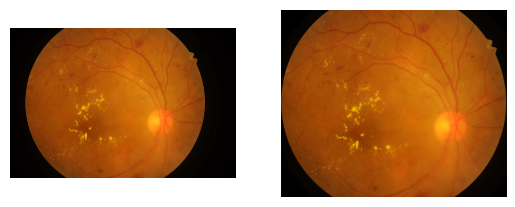

In [7]:
'''img_path = sorted(glob.glob(os.path.join(data_dir, str('test'+'_images'),'*', '*')))[1]'''
img_path=sorted(glob.glob(os.path.join(original_data_dir, 'Image','*', '*',)))[1]
img_original = cv2.imread(img_path)
img = img_crop(img_original)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [4]:
def img_resize(img, mode, size):
    if size == 1024:
        train_size = 1200
        val_test_size = 1024
    elif size == 512:
        train_size = 600
        val_test_size = 512
    if mode == 'train':
        if min(img.shape[0], img.shape[1]) <= train_size: # 이미지 size가 1600보다 작아서 확대해야 하는 경우
            img = cv2.resize(img, dsize=(train_size,train_size), interpolation=cv2.INTER_CUBIC)
        else:   # 이미지 size가 1024보다 커서 축소 해야 하는 경우
            img = cv2.resize(img, dsize=(train_size,train_size), interpolation=cv2.INTER_AREA)
    elif mode == 'val':
        if min(img.shape[0], img.shape[1]) <= val_test_size: # 이미지 size가 1024보다 작아서 확대해야 하는 경우
            img = cv2.resize(img, dsize=(val_test_size,val_test_size), interpolation=cv2.INTER_CUBIC)
        else:   # 이미지 size가 1024보다 커서 축소 해야 하는 경우
            img = cv2.resize(img, dsize=(val_test_size,val_test_size), interpolation=cv2.INTER_AREA)
    elif mode == 'test':
        if min(img.shape[0], img.shape[1]) <= val_test_size: # 이미지 size가 1024보다 작아서 확대해야 하는 경우
            img = cv2.resize(img, dsize=(val_test_size,val_test_size), interpolation=cv2.INTER_CUBIC)
        else:   # 이미지 size가 1024보다 커서 축소 해야 하는 경우
            img = cv2.resize(img, dsize=(val_test_size,val_test_size), interpolation=cv2.INTER_AREA)
    return img

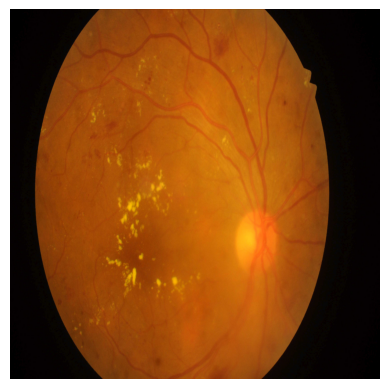

In [8]:
'''img_path = sorted(glob.glob(os.path.join(data_dir, str('test'+'_images'),'*', '*')))[1]'''
img_path=sorted(glob.glob(os.path.join(original_data_dir, 'Image','*', '*',)))[1]
img = cv2.imread(img_path)
img = img_resize(img, 'test', 1024)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

##### Ben Graham's preprocessing

In [5]:
def preprocessing(data_path, mode, size):
    '''
    Input: image path
    Output: image after applying denoising and CLAHE + Resize
            mode == train -> size = (1600, 1600, 3)
            mode == val -> size = (1024, 1024, 3)
    '''
    img = cv2.imread(data_path)
    #img = img_crop(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), 30), -4 ,128)
    img_H, img_W = img.shape[0], img.shape[1]
    img = img[int(img_H * 0.03) : img_H - int(img_H * 0.03),int(img_W * 0.03) : img_W - int(img_W * 0.03)]      # 위 아래 일부 제거
    img_H, img_W = img.shape[0], img.shape[1]
    ret = max(img_H, img_W)
    circle_mask = np.zeros([ret, ret, 3], dtype = "uint8")
    cv2.circle(circle_mask, (int(ret/2), int(ret/2)), int(ret/2 * 0.95), (1, 1, 1), -1)         # 원 마스크 만들기 (RGB 1,1,1로 검은 색) -1로 내부 채우기
    
    # 패딩: w가 길면 h를 (w-h)/2만큼 위아래 패딩, h가 길면 h를 (h-w)/2만큼 위아래 패딩
    if img_H < img_W:
        gap = img_W - img_H
        if gap % 2 == 1:
            top = int(gap/2)
            bottom = top + 1
        else:
            top = int(gap/2)
            bottom = top
        img = cv2.copyMakeBorder(img, top, bottom, 0, 0, cv2.BORDER_CONSTANT,value=0)   # padding
    
    if img_H > img_W:
        gap = img_H - img_W
        if gap % 2 == 1:
            left = int(gap/2)
            right = left + 1
        else:
            left = int(gap/2)
            right = left
        img = cv2.copyMakeBorder(img, 0, 0, left, right, cv2.BORDER_CONSTANT,value=0)

	# 6. 원으로 Crop 후 resize 이후 crop하기
    img = img * circle_mask
    img = img_crop(img)
    img = img_resize(img, mode=mode, size = size)
    return img

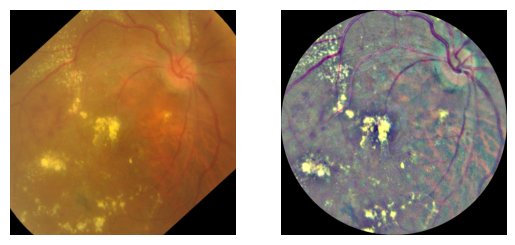

In [10]:
'''img_path=sorted(glob.glob(os.path.join(original_data_dir, 'Image','*', '*',)))[1]'''
img_path = './original data/sorted/aug/0c917c372572_aug_1.jpg'
img = preprocessing(img_path, mode='train', size=1024)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img)
plt.axis('off')
plt.show()

In [6]:
data_dir = '.'

def preprocess_and_save(mode, path_list, size):
    print('start preprocessing...')
    completed_list = sorted(glob.glob(os.path.join(data_dir, 'preprocessed_'+str(size), str(mode), '*')))
    completed_list_name = [os.path.split(x)[-1] for x in completed_list]
    working_list = [x for x in path_list if os.path.split(x)[-1] not in completed_list_name]
    for img_path in tqdm(working_list):
        img_name = os.path.split(img_path)[-1]
        img = preprocessing(img_path, mode=mode, size=size)
        cv2.imwrite(os.path.join(data_dir, 'preprocessed_'+str(size), str(mode), img_name), img)
    print('finish!')

In [7]:
total_file_path = sorted(glob.glob(os.path.join(original_data_dir, 'sorted','*', '*')))

train_csv = pd.read_csv(os.path.join(data_dir,'train_label.csv'), index_col=0)
train_id = train_csv.index.to_list()
train_path = [x for x in total_file_path if os.path.basename(x).split('.')[0] in train_id]
print("print(len(train_csv)): ", len(train_csv))
print("len(train_path): ", len(train_path))

print(len(train_csv)):  27439
len(train_path):  27439


In [34]:
val_csv = pd.read_csv(os.path.join(data_dir,'val_label.csv'), index_col=0)
val_id = val_csv.index.to_list()
val_path = [x for x in total_file_path if os.path.basename(x).split('.')[0] in val_id]
print("print(len(val_csv)): ", len(val_csv))
print("len(val_path): ", len(val_path))

print(len(val_csv)):  8487
len(val_path):  8487


In [35]:
test_csv = pd.read_csv(os.path.join(data_dir,'test_label.csv'), index_col=0)
test_id = test_csv.index.to_list()
test_path = [x for x in total_file_path if os.path.basename(x).split('.')[0] in test_id]
print("print(len(test_csv)): ", len(test_csv))
print("len(test_path): ", len(test_path))

print(len(test_csv)):  8487
len(test_path):  8487


##### 1024로 preprocess

In [40]:
preprocess_and_save('test', test_path, 1024)

start preprocessing...


  0%|          | 0/8487 [00:00<?, ?it/s]

finish!


In [41]:
preprocess_and_save('val', val_path, 1024)

start preprocessing...


  0%|          | 0/8487 [00:00<?, ?it/s]

finish!


In [46]:
preprocess_and_save('train', train_path, 1024)

start preprocessing...


  0%|          | 0/27439 [00:00<?, ?it/s]

finish!


##### 512로 preprocess

In [47]:
preprocess_and_save('test', test_path, 512)

start preprocessing...


  0%|          | 0/8487 [00:00<?, ?it/s]

finish!


In [48]:
preprocess_and_save('val', val_path, 512)

start preprocessing...


  0%|          | 0/8487 [00:00<?, ?it/s]

finish!


In [8]:
preprocess_and_save('train', train_path, 512)

start preprocessing...


  0%|          | 0/27439 [00:00<?, ?it/s]

finish!


### [Delete File]

In [ ]:
train_csv = pd.read_csv(os.path.join(data_dir,'train_label.csv'), index_col=0)
train_id = train_csv.index.to_list()

not_in_train_path = [x for x in total_file_path if os.path.basename(x).split('.')[0] not in train_id]

In [25]:
print("len(not_in_train_path): ", len(not_in_train_path))

len(not_in_train_path):  71933


In [23]:
print(len(total_file_path))

106626


In [27]:
for path in tqdm(not_in_train_path):
    if os.path.isfile(path):
        os.remove(path)
    else:
        continue

  0%|          | 0/71933 [00:00<?, ?it/s]